In [ ]:
# 네이버 지식인 검색 결과에 대한 토픽 분석
# - naver_kin.py 모듈을 참조해서 작업
# 검색어: 제주도
# 데이터: 크롤링을 이용하여 수집(500개 이상)
# 네이버 API 이용 데이터 수집
# 수집 결과 저장은 질문.txt / 답변.txt

In [ ]:
# 데이터 갖고 왔으면 토픽 분석
# - 형태소 분석 (명사, 형용사, 부사만 추출)
# - 질문에 대한 단어 빈도 수(상위 50개 차트 출력) + 워드 클라우드
# - 답변에 대해서도 단어 빈도 + 워드 클라우드
# - TF - IDF 계산
# - 단어에 대한 연관 분석 및 networkx 이용해서 시각화

In [15]:
all = [var for var in globals() if var[0] != "_"]
for var in all:
    del globals()[var]

In [16]:
from bs4 import BeautifulSoup as bs
from urllib import request
from urllib.request import quote
import urllib
import requests
import pandas as pd
import matplotlib.pyplot as plt
import naver_kin
from tqdm import tqdm
import re
import os
import sys
import json
from konlpy.tag import Okt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori

In [17]:
encText = "제주도"
for i in tqdm(range(1, 501,100)):
  
    reg_link=naver_kin.get_Nav_client(encText, i) # 질문을 txt로 저장

    # link를 이용해 세부 내용 가져와 파일에 기록하기
    for link in reg_link:
        naver_kin.get_write(encText, link)

print("=== End ===")

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [07:24<00:00, 88.84s/it]

=== End ===


In [18]:
# 저장한 파일 읽어오기
f= open('./제주도_질문.txt')
txtData = f.readlines()
print(txtData[:10])
f.close()

['제주도 농사\n', '제주도는 지표수가 부족해서 밭농사가 주로 이루어지잖아요제주도의 용천대를 따라서는 논농사가 이루어지나요?\n', '\n', '제주도 북쪽 코스\n', '안녕하세요 군대 가기전에 여자친구와 제주도를 갈려고 합니다 제주도 북쪽으로 가볼만한곳 맛집 추천해주세요!!!\n', '\n', '\n', '\n', '\n', '제주도 혼자 여행\n']


In [19]:
# 데이터를 한 줄 단위로 갖고 와서 명사, 형용사, 부사만 추출
okt = Okt()
New_text=[]

for i in range(len(txtData)):
    if len(re.sub('[\s]','',txtData[i])) == 0:
        continue
    else:
        New_text.append(okt.pos(re.sub('[\s]','',txtData[i])))

In [20]:
# 명사 / 동사만 추출
Noun_Verb=[]

for wl in New_text:
    
    for t, p in wl:
        
        if p == 'Noun' or p == 'Verb':
            Noun_Verb.append(t)

Noun_Verb[:5]

['제주도', '농사', '제주도', '지표수', '밭농사']

In [21]:
# 단어 빈도수 계산
from collections import Counter

txt_cnt_df=pd.DataFrame(Counter(Noun_Verb).most_common(), columns = ['단어', '빈도 수'])
txt_cnt_df.sort_values(by = '빈도 수', ascending = False)

,단어,빈도 수
0,제주도,256
1,여행,63
2,박,39
3,곳,36
4,렌트카,36
...,...,...
489,알고있고,1
490,않는것,1
491,가고싶다는,1
492,해주고싶다는,1


<AxesSubplot:>

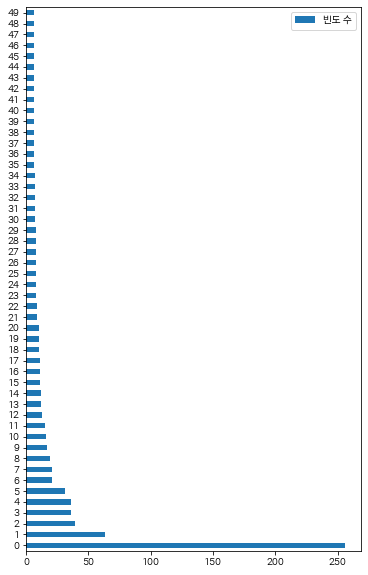

In [22]:
txt_cnt_df.iloc[:50].plot(kind='barh',figsize=(6,10))

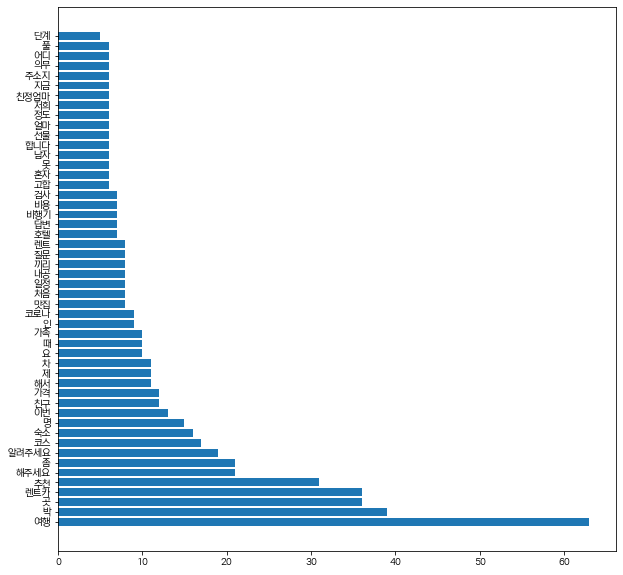

In [23]:
# 검색 단어를 제외한 가장 많이 언급되는 상위 50개 단어 현황을 그래프로 표시
plt.figure(figsize=(10,10))

plt.rc('font', family = 'Nexon Lv2 Gothic')

txt_cnt_df = txt_cnt_df[txt_cnt_df['단어'] != encText]

plt.barh(txt_cnt_df['단어'].iloc[:50], txt_cnt_df['빈도 수'].iloc[:50])
plt.show()

In [24]:
# 명사 / 동사만 추출
Noun_Verb = []
for wl in New_text:
    txt=""
    for t, p in wl:
        if p == "Noun" or p == "Verb":
            txt += t+" "
    Noun_Verb.append(txt)

Noun_Verb[:5]

['제주도 농사 ',
 '제주도 지표수 밭농사 가주 이루어지잖아요 제주도 용천 따라서 논 농사 이루어지나요 ',
 '제주도 북쪽 코스 ',
 '군대 기전 여자친구 제주도 갈려 고합 제주도 북쪽 볼 곳 맛집 추천 해주세요 ',
 '제주도 혼자 여행 ']

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tv=TfidfVectorizer().fit(txtData)
print(tv.transform(txtData).toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [26]:
features = tv.get_feature_names()
df=pd.DataFrame(tv.transform(Noun_Verb).toarray(),columns=features)
df.head()

C:\ProgramData\Miniconda3\envs\kdig\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,100,10년정도,10대,10만원,10만원이,10월,10월2일부터8일까지,10월에,10월초,11,...,활성한곳여행,회사,후카도,휴가나와서,휴가보냈다,흐리고일요일은,흔치않은,힘들어하시는,힘들어하시지,힙한것도
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# 명사 / 동사만 추출
Noun_Verb = []
for wl in New_text:
    lst=[]
    
    for t, p in wl:
        
        if p == "Noun" or p == "Verb":
            
            lst.append(t)
    
    Noun_Verb.append(txt)

Noun_Verb[:2]

['제 내년 일단 정도 숙소 구해 여행 겸 숙소 제공 되는 일자리 구해 남자 이구 살 제주도 숙소 제공 되는 일자리 일자리 추천 하시나요 차는 배타 제주도 가져갈 생각 가져가는게나 까요 안 가지고가는게 나을까요 제주도 여름 가을 겨울 날씨 좀 알려주세요 ',
 '제 내년 일단 정도 숙소 구해 여행 겸 숙소 제공 되는 일자리 구해 남자 이구 살 제주도 숙소 제공 되는 일자리 일자리 추천 하시나요 차는 배타 제주도 가져갈 생각 가져가는게나 까요 안 가지고가는게 나을까요 제주도 여름 가을 겨울 날씨 좀 알려주세요 ']

In [ ]:
tren = TransactionEncoder()
tren_arr = tren.fit(Noun_Verb).transform(Noun_Verb)
tren_df = pd.DataFrame(tren_arr, columns = tren.columns_)

aprItem = apriori(tren_df, min_support=0.3, use_colnames=True)
aprItem

In [ ]:
from mlxtend.frequent_patterns import association_rules
association_rules(aprItem, metric='lift', min_threshold=0.2)

In [ ]:
# 네트워크 그래프
from apyori import apriori

result=(list(apriori(Noun_Verb, min_support=0.3)))
df_apy = pd.DataFrame(result)
df_apy.head()

In [ ]:
df_apy['length'] = df['items'].apply(lambda x: len(x))
df_apy = df_apy[(df_apy['length']==2) & 
                (df_apy['support'] >=0.1)].sort_values(by='support', ascending=False)
df_apy.head(10)

In [ ]:
import networkx as nx

# 그래프 정의
G1 = np.Graph()
arn = df_apy['items']
G1.add_edges_from(arn)

In [ ]:
# 노드와 엣지, 페이지 랭크
pr = nx.pagerank(G1)
nsize = np.array([v for v in pr.values()])
nsiz = 2000*(nsiz - min(nsize)) / (max(nsize - min(nsize))

In [ ]:
# 레이아웃
#pos = nx.random_layout(G)
#pos = nx.shell_layout(G)
pos = nx.circular_layout(G)

# 그래프 그리기
plt.figure(figsize=(16,12))
plt.axis('off')
nx.draw_networkx(G1, font_family = 'Nexon Lv2 Gothic', font_size = 15, pos = pos,
                node_color = list(pr.values()), node_size = nsize, alpha = 0.8,
                edge_color = '0.5', cmap = plt.cm.YlGn)